[(0, 1), (0, 100)]

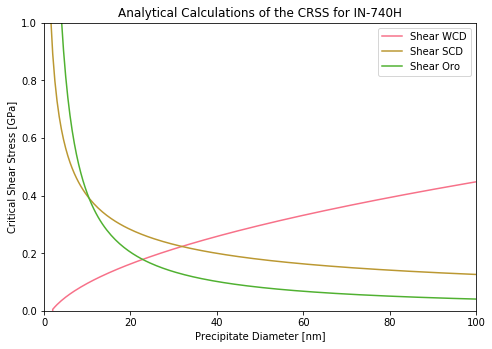

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math as m
import seaborn as sns

def GPa(number):
    if number>10000:
        convert = number/(10**9)
    else:
        convert = number * (10**9)
    return convert

def nm(number):
    if number<(0.001):
        convert = number*(10**9)
    else:
        convert = number * (10**-9)
    return convert

def convert_to_GPa (array):
    convert_array = []
    for number in array:
        convert=GPa(number)
        convert_array.append(convert)
    return convert_array

def convert_to_nm (array):
    convert_array = []
    for number in array:
        convert=nm(number)
        convert_array.append(convert)
    return np.array(convert_array)

'''
For this model, we will be using several theoretical equations to calculate the 
critically resolved shear stress (CRSS) as precipiates grow. For more information please read:
Oh, J. H., Yoo, B. G., Choi, I. C., Santella, M. L. & Jang, J. Il. Influence of thermo-mechanical treatment on the precipitation strengthening behavior of Inconel 740, a Ni-based superalloy. J. Mater. Res. 26, 1253–1259 (2011).
'''

'''lets first set up our constants that we will use in the equation:'''

#apbe is the anti-phase boundary energy
apbe = 0.42 #units J/m^2
#apbe = 0.28 #this is the APBE of IN-740 (not 740H), used to compare to literature

#b is burgers vector calculated from a=3.57A and plane {111}
b = nm(m.sqrt(3)*(3.57/2))/10. #units A
#b=nm(0.254) #this is the burgers vector of IN-740 (not 740H)

#G is the shear modulus. This is taken from a material data sheet from Special Metals
#But shear modulus can also equal (0.5E/(1+v)) where v is Poissons ratio, 0.35 (also taken from datasheet)
g = GPa(79) #units GPa
#g= ((0.5)*GPa(221))/(1+0.35) #this is the shear modulus of IN-740 (not 740H)

#T is the line tension of the dislocation.
t = (0.5)*g*(b**2)

#A is the numerical factor depending on the morpology of the particles (0.72 for spherical particles)
A = 0.72

#w is a constant that accounts for the elastic replusion between the dislocations
w = 1 #it is assumed to be unity for simplicity

'''now lets include our variables:'''

#d is the precipitate diameter
d_space = np.arange(nm(0.5),nm(100.5),nm(0.5))
d_wcd = np.arange(nm(0.5),nm(100.5),nm(0.5)) #[nm] but calling with nm() makes it in m
#we start at 3.5 nm or else the wcd will be negative
d_scd = np.arange(nm(0.5),nm(100.5),nm(0.5)) #the last term has a -1 term so 7.03 is minimum to keep above 1
#d=nm(20)

#f is the volume fraction of gamma prime
#f = np.arange(0,0.5,0.0025)
f = 0.1 #for now lets keep this to 2 dimensions

#space is the interpartile spacing between precipiates and is often simplified as:
space = (2*d_space*(1-f))/(3*f) #[nm]

'''now start with the equations'''
#wcd is the weak coupled dislocation theory
wcd_raw = (
    ((0.5)*
    ((apbe/b)**(3./2.))*
    (((b*d_wcd*f)/t)**0.5)
     *A)
    - ((0.5)*(apbe/b)*f)
)
wcd = convert_to_GPa (wcd_raw)

#scd is the strongly coupled dislocation theory. Orowan typically wins out so it doesn't matter too much
scd_raw = (
    (0.8660254037844386)*
    ((t*w*(f**0.5))/(b*d_scd))
    *((((1.28*((d_scd*apbe)/(w*t)))**0.5)))) #the first term is sqrt(3)/2
#scd_raw = ((0.8660254037844386)*((t*w*(f**0.5))/(b*d_scd))*((((1.28*d_scd*apbe)/(w*t))-1)**0.5)) #the first term is sqrt(3)/2
#paper I was using had the -1 in there. THE -1 SHOULD NOT BE IN THERE. They lied to me. Curve has completely different shape
scd = convert_to_GPa (scd_raw)

#orowan is orowan bowing mechanism, most important, especially as precipiates coarsen
oro_raw = (g*b)/space
oro = convert_to_GPa (oro_raw)

d_space_plot = convert_to_nm (d_scd)
d_wcd_plot = convert_to_nm (d_wcd)
d_scd_plot = convert_to_nm (d_scd)

#print (scd)
'''Plotting the models'''
#lets get our plot set up
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Analytical Calculations of the CRSS for IN-740H")
ax.set_xlabel('Precipitate Diameter [nm]')
ax.set_ylabel('Critical Shear Stress [GPa]')
#ax.set_facecolor('black')
sns.set_palette(sns.husl_palette())

#plotting WCD
plt.plot(d_wcd_plot,wcd,label='Shear WCD')
#plotting SCD
plt.plot(d_scd_plot,scd,label='Shear SCD')
#plotting Orowan bowing
plt.plot(d_space_plot,oro,label='Shear Oro')
plt.legend()
ax.set(xlim=(0, 100), ylim=(0, 1))

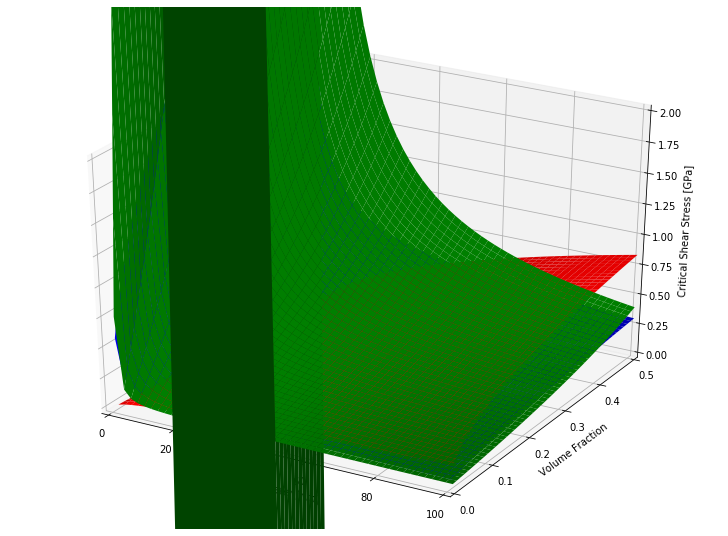

In [36]:
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 12.8, 9.6
from matplotlib import cm, colors
from matplotlib import animation

'''
______________________________________________________________________
Alright so that looks great! Let's add an additional level of 
complexity. These equations depend on two variables:
precipitate diameter (d) and the volume fraction (f). We can't assume
that we only have one volume fraction, as in reality the preciptiates
will nucleate and grow. However, we aren't starting in the solution
treated condition either (at least for 740H). Lets add the dimension
of volume fraction and make a 3D plot, just to see how it changes. 

Since we have a 3D plot, we need to put our shear strength in terms of
functions f(x,y). Each function will take the given diameter (d) and 
the volume fraction (f), calculate the theoretical shear strength, 
convert to GPa, and return the single value for each single value of 
d and f. Before, we were doing essentially matrix manipulation, 
turning the diameter matrix into a shear strength matrix. Here, we can
have a 3D plot, but it essentially requires a loop. These functions 
could be done with lambdas instead, but I learned about lambdas 
yesterday so i'm not gonna implement them just yet ;)
______________________________________________________________________
'''
def wcd_shear (d, f): 
    '''
    I didn't understand this at first, hence the commented out code.
    I'll leave the commented out code here to show what mistakes I
    made, namely trying to return a variable name instead of the 
    equation and trying to convert to GPa and nm. Instead, I made it so
    that the calculation d is different than the plotting d. I don't
    want to plot from 1*10^-9 to 100*10^-9, I want to plot from 1 to 100.
    Unfortunetly, that will mess up the values for shear strength.
    I'm deleting this for the other equations.
    '''
    #wcd is the weak coupled dislocation theory
    #wcd_raw_c =
    return (
        (((0.5)*
        ((apbe/b)**(3./2.))*
        (((b*d*f)/t)**0.5)
         *A)
        - ((0.5)*(apbe/b)*f))/(10**9)
    )
    #wcd_change = convert_to_GPa (wcd_raw_c)
    #return wcd_change

def scd_shear (d, f):
    #scd is the strongly coupled dislocation theory. Orowan typically wins out so it doesn't matter too much
    return (
    ((0.8660254037844386)*
    ((t*w*(f**0.5))/(b*d))
    *((((1.28*((d*apbe)/(w*t)))**0.5))))
        /(10**9))#the first term is sqrt(3)/2

def oro_shear (d, f):
    #orowan is orowan bowing mechanism, most important, especially as precipiates coarsen
    return (((g*b)/((2*d*(1-f))/(3*f)))/(10**9))

'''
______________________________________________________________________
Lets get to our variables now, d and f. D will be from 0.5 nm to 100.5
nm but will not be in raw form, so slight change will be made to
functions above to convert the d to m (input 0.5nm change to 
0.5*10^-9). This is to ensure the plot looks nice. Volume fraction
will be from 0 to 50% but obviously will be in fraction form, not
percentage.
______________________________________________________________________
'''
#d_calc is the precipitate diameter
d_x = np.linspace(nm(0.5),nm(100.5),50) #im doing 50 for now, but originally it was 200 pts
d_plot = np.linspace(0.5,100.5,50)

#f is the volume fraction of gamma prime
f_y = np.linspace(0.01,0.51,50) #the first term should change depending on the spacing
#we can't start with 0 because the Orowan bowing equation has a division by f

D, F = np.meshgrid(d_x, f_y) #we set up all the points in the 3D space
Z_wcd = wcd_shear (D, F)
Z_scd = scd_shear (D, F)
Z_oro = oro_shear (D, F)

D_plot, F = np.meshgrid(d_plot, f_y) 

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Precipitate Diameter [nm]')
ax.set_ylabel('Volume Fraction')
ax.set_zlabel('Critical Shear Stress [GPa]');
ax.set(xlim=(0, 100), ylim=(0, 0.5), zlim=(0,2))

#ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(D_plot, F, Z_wcd, color='r')

#ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(D_plot, F, Z_scd, color='b')

#ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(D_plot, F, Z_oro, color='g')

In [ ]:
def init():
    ax.plot_wireframe(D_plot, F, Z_wcd, color='r')
    #ax.scatter(xx, yy, zz, marker='o', s=20, c="goldenrod", alpha=0.6)
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])